<a href="https://colab.research.google.com/github/bachvu98/Policy-NLP/blob/master/Do_Not_Track_Model_Development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
import re
import time
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from os import listdir
from sklearn import svm
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from lxml import etree, html

%matplotlib inline
nltk.download('stopwords')
nltk.download('punkt')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
segments = pd.read_csv('/content/drive/My Drive/OPP-115/OPP-115/binary_segment_categories.csv',index_col=0)
segments = segments[['Policy UID','segment_id','segments','do_not_track']]
segments.head()

,Policy UID,segment_id,segments,do_not_track
0,20,0,strong privacy policy strong br br strong effe...,0
1,20,1,privacy policy apply site maintained company o...,0
2,20,2,visiting site accepting practice described pri...,0
3,20,3,strong information collected strong br br coll...,0
4,20,4,strong personally identifiable information str...,0


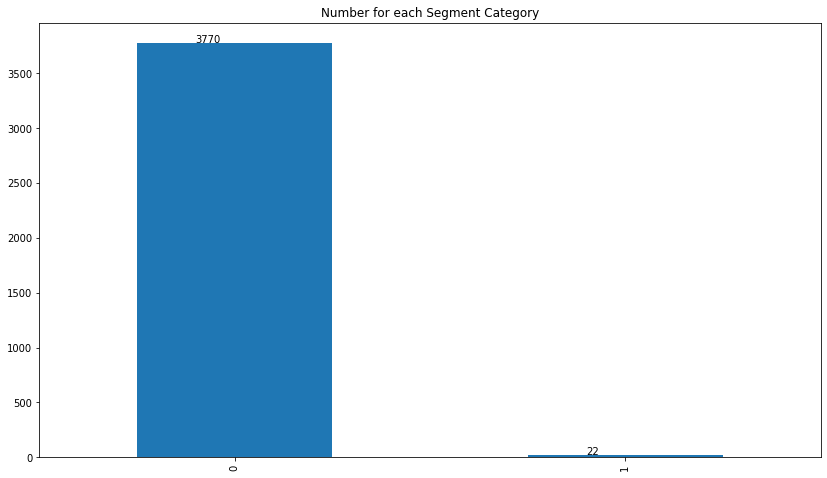

In [3]:
ax = segments['do_not_track'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number for each Segment Category")

for index, value in enumerate(segments['do_not_track'].value_counts()):
    ax.text(index-0.1, value+10, "{}".format(value))

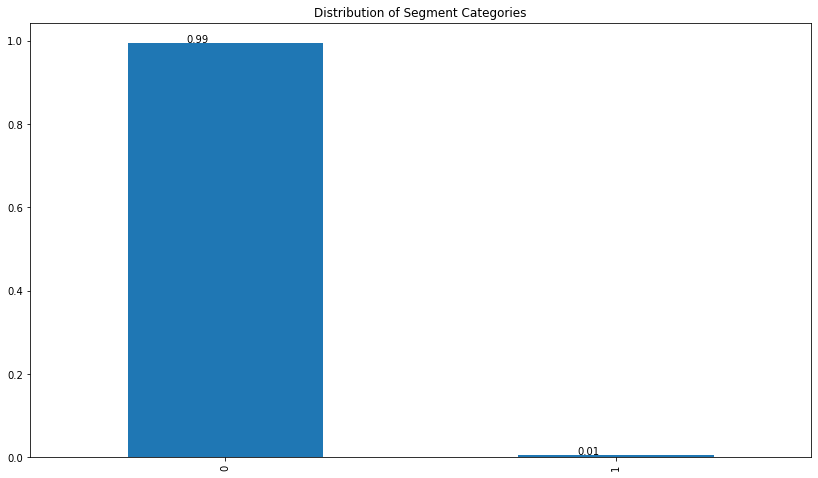

In [4]:
ax = segments['do_not_track'].value_counts(normalize=True).plot(kind='bar',
                                    figsize=(14,8),
                                    title="Distribution of Segment Categories")

for index, value in enumerate(segments['do_not_track'].value_counts(normalize=True)):
    ax.text(index-0.1, value+0.002, "{:.2f}".format(value))

In [32]:
# create the object of tfid vectorizer
tfid_vectorizer = TfidfVectorizer("english", ngram_range=(1,2), use_idf=True, max_df=0.7, min_df=5)
# fit the vectorizer using the text data
tfid = tfid_vectorizer.fit(segments['segments'])
# collect the vocabulary items used in the vectorizer
dictionary = tfid_vectorizer.vocabulary_.items()

tfid_matrix = tfid_vectorizer.transform(segments['segments']).todense()
feature_names = tfid_vectorizer.get_feature_names()

# store the tf-idf array into pandas dataframe
df = pd.DataFrame(tfid_matrix, columns=feature_names)
df['output'] = segments['do_not_track']
df

,aaa,abide,ability,ability accept,ability access,abita,abitacom,able,able access,able identify,able provide,able take,able use,absolute,absolute security,abuse,acc,accept,accept change,accept cooky,accept request,acceptance,acceptance privacy,accepted,accepting,accepting new,accepting practice,access,access account,access br,access certain,access change,access contact,access control,access cooky,access correct,access correction,access database,access disclosure,access enforcement,...,word,work,work behalf,working,world,would,would like,write,write kaleida,write privacy,writing,written,written authorization,written consent,written request,wwwaboutadsinfo,yahoo,yahoo ad,yahoo also,year,year age,year free,year old,yet,york,york ny,york time,young,youre,youre using,youtube,youve,youve requested,zacks,zacks investment,zackscom,zip,zip code,zone,output
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041406,0.06039,0.0,0.0,0.0,0.0,0.0,0.050133,0.0,0.057705,0.025173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.060832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.137725,0.17512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.

In [9]:
#Split data using 30%/70% split
segments_train, segments_test, targets_train, targets_test = train_test_split(df[feature_names], df['output'], test_size=0.3, random_state=0)

In [18]:
alpha_list = np.linspace(150,250,21)
alpha_list = np.around(alpha_list, decimals=4)
alpha_list

array([150., 155., 160., 165., 170., 175., 180., 185., 190., 195., 200.,
       205., 210., 215., 220., 225., 230., 235., 240., 245., 250.])

In [19]:
kf = StratifiedKFold(n_splits=5, random_state=0, shuffle=False)
params = {'C': alpha_list,
          'random_state': [0]}

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [12]:
classifier = LogisticRegression(random_state=0)
cross_val_score(classifier, segments_train, targets_train, cv=kf)

array([0.99623352, 0.99435028, 0.99435028, 0.99435028, 0.99622642])

In [30]:
classifier.fit(segments_train, targets_train)
base_preds = classifier.predict(segments_test)
recall_score(targets_test, base_preds)

0.0

In [20]:
grid_no_up = GridSearchCV(classifier, param_grid=params, cv=kf, scoring='f1').fit(segments_train, targets_train)
print(grid_no_up.best_params_)
print(grid_no_up.best_score_)

{'C': 150.0, 'random_state': 0}
0.9977401129943502


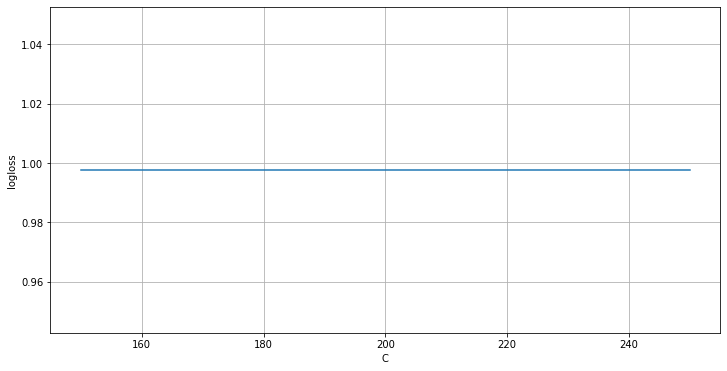

In [22]:
results = pd.DataFrame()
# collect parameter list
results['alpha'] = grid_no_up.cv_results_['param_C'].data
# collect test scores
results['score'] = grid_no_up.cv_results_['mean_test_score'].data

plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(results['alpha'], results['score'])
plt.xlabel('C')
plt.ylabel('logloss')
plt.grid()

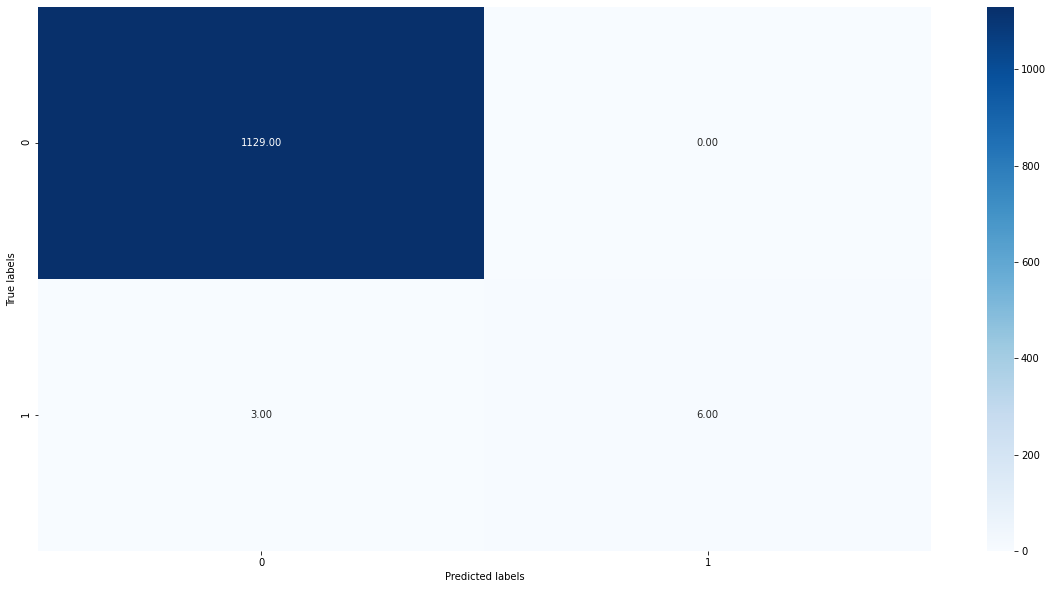

In [23]:
grid_no_up_preds = grid_no_up.best_estimator_.predict(segments_test)
#labels = segments['do_not_track'].unique()
cm = confusion_matrix(targets_test.astype(str), grid_no_up_preds.astype(str) )
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.rcParams['figure.figsize'] = (20, 10)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=True, ax = ax)
#ax.set_xticklabels([''] + labels, rotation=90)
#ax.set_yticklabels([''] + labels, rotation=0)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

In [24]:
#Quick diagnostics
print(classification_report(targets_test.astype(str),grid_no_up_preds.astype(str)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1129
           1       1.00      0.67      0.80         9

    accuracy                           1.00      1138
   macro avg       1.00      0.83      0.90      1138
weighted avg       1.00      1.00      1.00      1138



In [25]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [26]:
imba_pipeline = make_pipeline(SMOTE(random_state=0), 
                             LogisticRegression(random_state=0))

new_params = {'logisticregression__' + key: params[key] for key in params}
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf, scoring='f1').fit(segments_train, targets_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [27]:
print(grid_imba.best_params_)
print(grid_imba.best_score_)

{'logisticregression__C': 150.0, 'logisticregression__random_state': 0}
0.7714285714285714


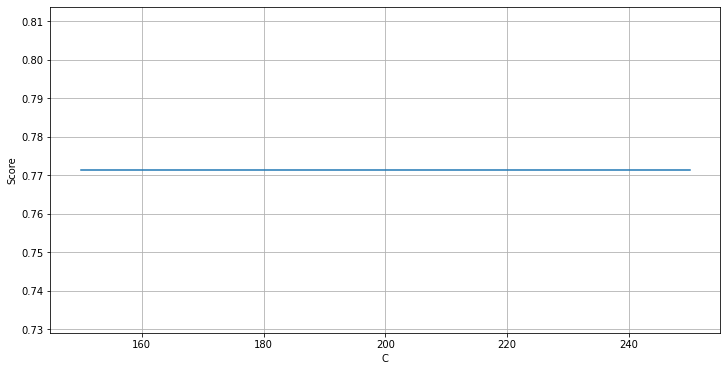

In [28]:
results = pd.DataFrame()
# collect alpha list
results['C'] = grid_imba.cv_results_['param_logisticregression__C'].data
# collect test scores
results['score'] = grid_imba.cv_results_['mean_test_score'].data

plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(results['C'], results['score'])
plt.xlabel('C')
plt.ylabel('Score')
plt.grid()

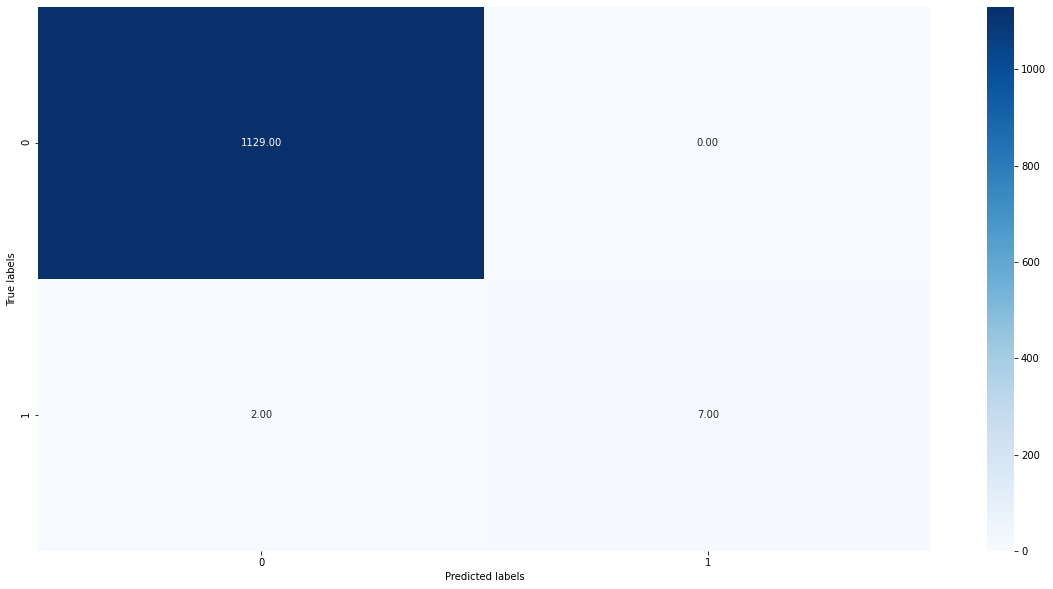

In [29]:
grid_imba_preds = grid_imba.best_estimator_.named_steps['logisticregression'].predict(segments_test)
#labels = segments['category_name'].unique()
cm = confusion_matrix(targets_test.astype(str), grid_imba_preds.astype(str))
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.rcParams['figure.figsize'] = (20, 10)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=True, ax = ax)
#ax.set_xticklabels([''] + labels, rotation=90)
#ax.set_yticklabels([''] + labels, rotation=0)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

In [30]:
#Quick diagnostics
print(classification_report(targets_test,grid_imba_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1129
           1       1.00      0.78      0.88         9

    accuracy                           1.00      1138
   macro avg       1.00      0.89      0.94      1138
weighted avg       1.00      1.00      1.00      1138



In [303]:
smote = SMOTE('minority', random_state=0)
segments_smote, targets_smote = smote.fit_sample(segments_train, targets_train)
smote_df = pd.concat([pd.DataFrame(segments_smote, columns=feature_names), pd.DataFrame(targets_smote, columns=['output'])], axis=1)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [304]:
smote_df['output'].value_counts()

1    2639
0    2639
Name: output, dtype: int64

In [306]:
#paramater selection
start_time = time.time()

parameters = [{'C': [0.001, 0.01, 0.1, 1, 10],
              'degree': [2, 3, 4],
              'kernel': ['rbf', 'poly', 'sigmoid'],
              'gamma':  [0.001, 0.01, 0.1, 1, 10],
              }]

params = {'n_estimators': [50,100,150],
          'random_state': [0]}

gs_clf = GridSearchCV(classifier, params, n_jobs=-1, cv=kf, scoring='recall_macro', verbose=1)
gs_clf = gs_clf.fit(smote_df[feature_names],smote_df['output'])
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')
print("Best parameter: ",gs_clf.best_params_)
print("Best score: ",gs_clf.best_score_) 

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   20.6s finished


Done training in 21.743385553359985 seconds.
Best parameter:  {'n_estimators': 50, 'random_state': 0}
Best score:  0.999810606060606


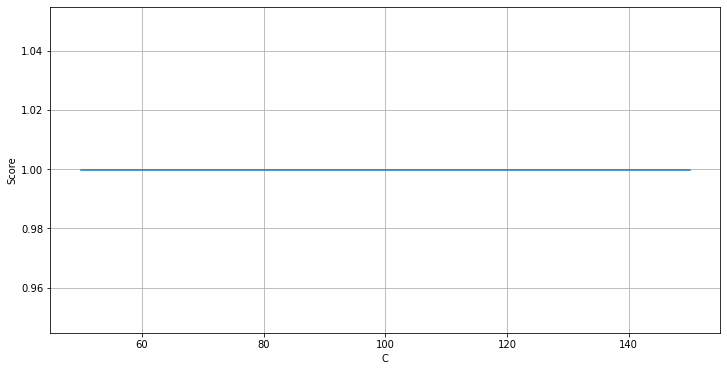

In [308]:
results = pd.DataFrame()
# collect alpha list
results['C'] = gs_clf.cv_results_['param_n_estimators'].data
# collect test scores
results['score'] = gs_clf.cv_results_['mean_test_score'].data

plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(results['C'], results['score'])
plt.xlabel('C')
plt.ylabel('Score')
plt.grid()

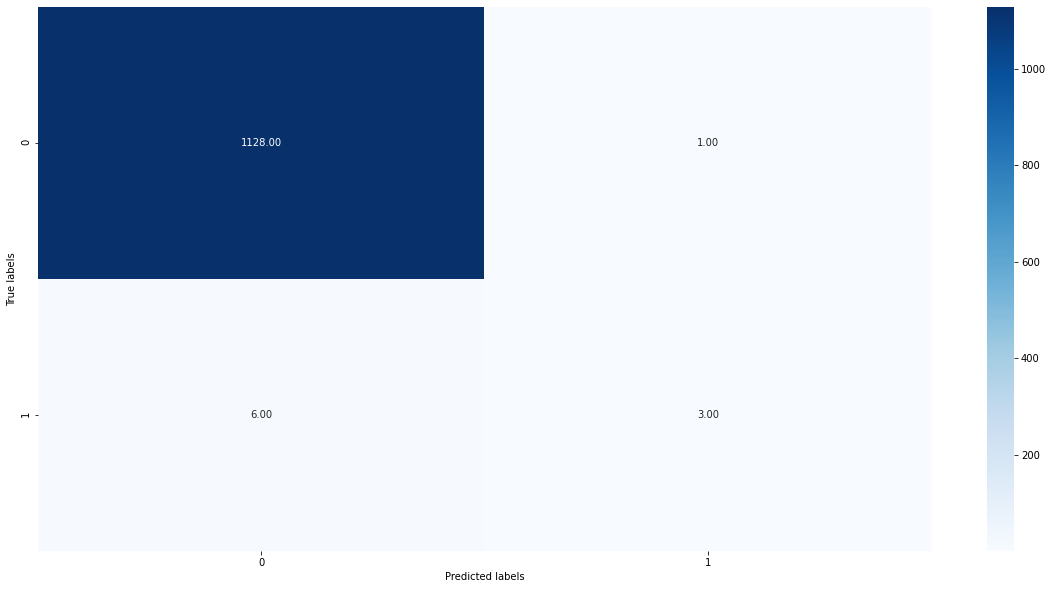

In [311]:
preds = gs_clf.predict(segments_test)
#labels = segments['category_name'].unique()
cm = confusion_matrix(targets_test.astype(str), preds.astype(str))
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.rcParams['figure.figsize'] = (20, 10)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=True, ax = ax)
#ax.set_xticklabels([''] + labels, rotation=90)
#ax.set_yticklabels([''] + labels, rotation=0)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

In [310]:
#Quick diagnostics
print(classification_report(targets_test.astype(str),preds.astype(str)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1129
           1       0.75      0.33      0.46         9

    accuracy                           0.99      1138
   macro avg       0.87      0.67      0.73      1138
weighted avg       0.99      0.99      0.99      1138

